# Online EM Algorithm for Hidden Markov Models

### Mohamed Benyahia & Lilian Say

In [1]:
import time
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

np.random.seed(42)

## Algo

In [13]:
class OnlineEMHMM:
    def __init__(self, X, q_theta, g_theta, s_func, bar_theta, n_min, gamma_schedule):
        """
        Initialize the Online EM algorithm.

        Parameters:
        - X: State space (set of possible hidden states)
        - q_theta: Transition probability function, q_theta(x', x)
        - g_theta: Emission probability function, g_theta(x, y)
        - s_func: Function for sufficient statistics, s(x', x, y)
        - bar_theta: Function to update theta in the M-step
        - n_min: Minimum number of observations before updating parameters
        - gamma_schedule: Function to compute step size gamma_n
        """
        self.X = X
        self.q_theta = q_theta
        self.g_theta = g_theta
        self.s_func = s_func
        self.bar_theta = bar_theta
        self.n_min = n_min
        self.gamma_schedule = gamma_schedule
        self.theta_updates = []

        self.theta = None
        self.phi = None
        self.rho = None
        self.t = 0

    def initialize(self, theta_0, nu, y_0):
        """Initialize parameters, phi, and rho."""
        self.theta = theta_0

        X_shape = len(self.X)

        g_theta_values = np.array([self.g_theta(theta_0, k, y_0) for k in self.X]).reshape(X_shape)        
        nu_array = np.array([nu[k] for k in self.X])
        numerator = nu_array * g_theta_values
        denominator = np.sum(numerator)
        
        self.phi = numerator / denominator

        
        self.rho = {'transition': np.zeros((X_shape,X_shape,X_shape)), 'emission': {key: np.eye(X_shape) for key in self.s_func(y_0).keys()}}
        
        for key in self.s_func(y_0).keys():
            self.rho['emission'][key] *= self.s_func(y_0)[key]
    
    def filter_update(self, y_next):
        """Recursive filter update."""
        q_theta_matrix = np.array([[self.q_theta(self.theta, k_prime, k) for k in self.X] for k_prime in self.X])
        g_theta_matrix = np.array([self.g_theta(self.theta, k, y_next) for k in self.X]).reshape(len(self.X))
           
        r_ij_matrix = (self.phi * q_theta_matrix.T).T
        numerator = np.sum(r_ij_matrix*g_theta_matrix, axis=0)
        denominator = numerator.sum() 

        self.phi = numerator / denominator
        

    def intermediate_update(self, y_next):
        """Update intermediate quantities for transition and emission statistics."""
        gamma_n = self.gamma_schedule(self.t + 1)
        n_states = len(self.X)
        
        q_theta_values = np.array([[self.q_theta(self.theta, i, j) for j in self.X] for i in self.X])

        r_ij_matrix = (self.phi * q_theta_values.T).T
        r_ij_denom = np.sum(r_ij_matrix, axis=0)
        r_ij_matrix /= r_ij_denom
    
        # Transition update
        T1 = np.zeros_like(self.rho['transition'])
        for k in range(len(self.X)):
            T1[:, k, k] = r_ij_matrix[:, k]
        sum_term = np.einsum('ijk,kl->ijl', self.rho['transition'], r_ij_matrix)
        rho_q_next = gamma_n * T1 + (1 - gamma_n) * sum_term
        
        self.rho['transition'] = rho_q_next
        
        # Emission update
        rho_g_next = {key: np.zeros((n_states, n_states)) for key in self.s_func(y_next).keys()}
        for stat_key in self.s_func(y_next).keys():
            delta_ik = np.eye(n_states)
            s_y_next = self.s_func(y_next)[stat_key]

            sum_term = self.rho['emission'][stat_key] @ r_ij_matrix

            rho_g_next[stat_key] = gamma_n * delta_ik * s_y_next + (1 - gamma_n) * sum_term

        self.rho['emission'] = rho_g_next

    def m_step(self):
        """Perform the M-step to update parameters theta."""
        if self.t >= self.n_min:
            sufficient_statistics = {'transition': np.zeros((len(self.X),len(self.X))), 'emission': {key: np.zeros(len(self.X)) for key in self.rho['emission'].keys()}}
            for component in ['transition', 'emission']:
                if component == 'transition':
                    sufficient_statistics[component] =np.einsum('ijk,k->ij', self.rho[component], self.phi)
                elif component == 'emission':
                    for stat_key in self.rho['emission'].keys():
                        sufficient_statistics[component][stat_key] = self.rho[component][stat_key] @ self.phi

            self.theta = self.bar_theta(sufficient_statistics)


    def step(self, y_next):
        """Perform a single step of the Online EM algorithm."""
        self.filter_update(y_next)
        self.intermediate_update(y_next)
        self.m_step()
        self.t += 1

    def run(self, observations):
        """Perform a full Online EM algorithm."""
        for y_next in observations:
            self.step(y_next)
            self.theta_updates.append(self.theta.copy())
        return self.theta_updates




## DEMONSTRATION

In [4]:
class MarkovChain(object):
    def __init__(self, transition_matrix, states):
        """
        Initialize the MarkovChain instance.
 
        Parameters
        ----------
        transition_matrix: 2-D array
            A 2-D array representing the probabilities of change of 
            state in the Markov Chain.
 
        states: 1-D array 
            An array representing the states of the Markov Chain. It
            needs to be in the same order as transition_matrix.
        """
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.states = states
        self.index_dict = {self.states[index]: index for index in 
                           range(len(self.states))}
        self.state_dict = {index: self.states[index] for index in
                           range(len(self.states))}
 
    def next_state(self, current_state):
        """
        Returns the state of the random variable at the next time 
        instance.
 
        Parameters
        ----------
        current_state: str
            The current state of the system.
        """
        return np.random.choice(
         self.states, 
         p=self.transition_matrix[self.index_dict[current_state], :]
        )
 
    def generate_states(self, current_state, time_step):
        """
        Generates the next states of the system.
 
        Parameters
        ----------
        current_state: str
            The state of the current random variable.
 
        no: int
            The number of future states to generate.
        """
        future_states = []
        for i in range(time_step):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
        return future_states

In [5]:
def generate_observation(state_space, transition_matrix, nu, time_step):
    chain = MarkovChain(transition_matrix=transition_matrix,
                                    states=state_space)
    init_state = np.random.choice(state_space)
    x = np.array(chain.generate_states(current_state=init_state, time_step=time_step))
    v = np.random.normal(0, nu, time_step)
    y = x + v
    return y

In [6]:
def generate_trajectories(state_space, transition_matrix, nu, n, num_trajectories):
    trajectories = []
    for i in range(num_trajectories):
        observations = generate_observation(state_space, transition_matrix, nu, n)
        trajectories.append(observations)
    return np.array(trajectories)

In [7]:
def run_online_em_for_trajectories(trajectories, state_space, theta_0, nu, q_theta, g_theta, s_gaussian, bar_theta, gamma_schedule):
    all_theta_updates = {'500': [], '2000':[], '8000':[]}
    
    for idx, observations in enumerate(trajectories):
        print(f"Running OnlineEMHMM for trajectory {idx + 1}/{len(trajectories)}...")
        y_0 = observations[0]
        online_em = OnlineEMHMM(state_space, q_theta, g_theta, s_gaussian, bar_theta, n_min=20, gamma_schedule=gamma_schedule)
        online_em.initialize(theta_0, nu, y_0)
        theta_updates = online_em.run(observations[1:])

        all_theta_updates['500'].append(theta_updates[500-1])
        all_theta_updates['2000'].append(theta_updates[2000-1])
        all_theta_updates['8000'].append(theta_updates[-1])

    print("Completed running OnlineEMHMM for all trajectories.")
    return all_theta_updates

In [8]:
def q_theta(theta, i, j):
    return theta['q'][i, j]

def g_theta(theta, k, y):
    mu = theta['mu'][k]
    sigma = theta['sigma']
    return norm.pdf(y, loc=mu, scale=sigma)


def s_gaussian(y):
    """
    Sufficient statistics for multivariate Gaussian emissions.

    Parameters:
    - y: Observation vector.

    Returns:
    - Dictionary of sufficient statistics {1, y, y y^2}.
    """
    return {
        'constant': 1,
        'mean': y,
        'covariance': y**2,
    }

def bar_theta(sufficient_statistics):
    transition = sufficient_statistics['transition']
    emission = sufficient_statistics['emission']

    numerator = transition
    denominator = np.sum(transition, axis=1)
    q_new = numerator/denominator

    mu_new = emission['mean']/emission['constant']
    sigma_new = np.sum(emission['covariance'] - (mu_new**2) * emission['constant'])/np.sum(emission['constant'])
    return {'q': q_new, 'mu': mu_new, 'sigma': sigma_new}

def gamma_schedule(n):
    return 1 / n**0.6

In [9]:
def plot_parameter_boxplots(all_values):
    labels = list(all_values.keys())
    q_by_time = np.zeros((100, 3))
    mu_by_time = np.zeros((100, 3))
    v_by_time = np.zeros((100, 3))

    for i, (key, values) in enumerate(all_values.items()):
        for j, t in enumerate(values):
            q = t['q'][0, 0]
            q_by_time[j, i] = q
            
            mu = t['mu'][0]
            mu_by_time[j, i] = mu
            
            v = t['sigma']
            v_by_time[j, i] = v

    # Reference values for horizontal dashed lines
    q_ref = 0.95
    mu_ref = 0.0
    v_ref = 0.5

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=False)
    fig.subplots_adjust(wspace=0.4)

    # Plot for q(1,1)
    axs[0].boxplot(q_by_time, tick_labels=labels, showmeans=True, meanline=True, patch_artist=True)
    axs[0].axhline(y=q_ref, color='m', linestyle='--', linewidth=1)
    axs[0].set_title(r'$q(1,1)$', fontsize=14)
    axs[0].set_xlabel('samples', fontsize=12)
    # axs[0].set_ylim(0.65, 1.0)

    # Plot for mu
    axs[1].boxplot(mu_by_time, tick_labels=labels, showmeans=True, meanline=True, patch_artist=True)
    axs[1].axhline(y=mu_ref, color='m', linestyle='--', linewidth=1)
    axs[1].set_title(r'$\mu(1)$', fontsize=14)
    axs[1].set_xlabel('samples', fontsize=12)
    # axs[1].set_ylim(-0.25, 0.25)

    # Plot for v
    axs[2].boxplot(v_by_time, tick_labels=labels, showmeans=True, meanline=True, patch_artist=True)
    axs[2].axhline(y=v_ref, color='m', linestyle='--', linewidth=1)
    axs[2].set_title(r'$v$', fontsize=14)
    axs[2].set_xlabel('samples', fontsize=12)
    # axs[2].set_ylim(0.35, 0.8)

    plt.tight_layout()
    plt.show()


In [10]:
state_space = [0, 1]
transition_matrix = np.array([[0.95, 0.05], [0.3, 0.7]])
nu = 0.5
n = 8000
num_trajectories = 100

trajectories = generate_trajectories(state_space, transition_matrix, nu, n, num_trajectories)
print(f"Generated {num_trajectories} independent trajectories of length {n}.")

theta_0 = {
    'q': np.array([[0.7, 0.3], [0.5, 0.5]]),
    'mu': np.array([[-0.5], [0.5]]),
    'sigma': np.array([2])
}
nu = {0: 0.5, 1: 0.5}

Generated 100 independent trajectories of length 8000.


In [11]:
all_theta_updates = run_online_em_for_trajectories(
    trajectories, state_space, theta_0, nu, q_theta, g_theta, s_gaussian, bar_theta, gamma_schedule
)

Running OnlineEMHMM for trajectory 1/100...
Running OnlineEMHMM for trajectory 2/100...
Running OnlineEMHMM for trajectory 3/100...
Running OnlineEMHMM for trajectory 4/100...
Running OnlineEMHMM for trajectory 5/100...
Running OnlineEMHMM for trajectory 6/100...
Running OnlineEMHMM for trajectory 7/100...
Running OnlineEMHMM for trajectory 8/100...
Running OnlineEMHMM for trajectory 9/100...
Running OnlineEMHMM for trajectory 10/100...
Running OnlineEMHMM for trajectory 11/100...
Running OnlineEMHMM for trajectory 12/100...
Running OnlineEMHMM for trajectory 13/100...
Running OnlineEMHMM for trajectory 14/100...
Running OnlineEMHMM for trajectory 15/100...
Running OnlineEMHMM for trajectory 16/100...
Running OnlineEMHMM for trajectory 17/100...
Running OnlineEMHMM for trajectory 18/100...
Running OnlineEMHMM for trajectory 19/100...
Running OnlineEMHMM for trajectory 20/100...
Running OnlineEMHMM for trajectory 21/100...
Running OnlineEMHMM for trajectory 22/100...
Running OnlineEMHMM

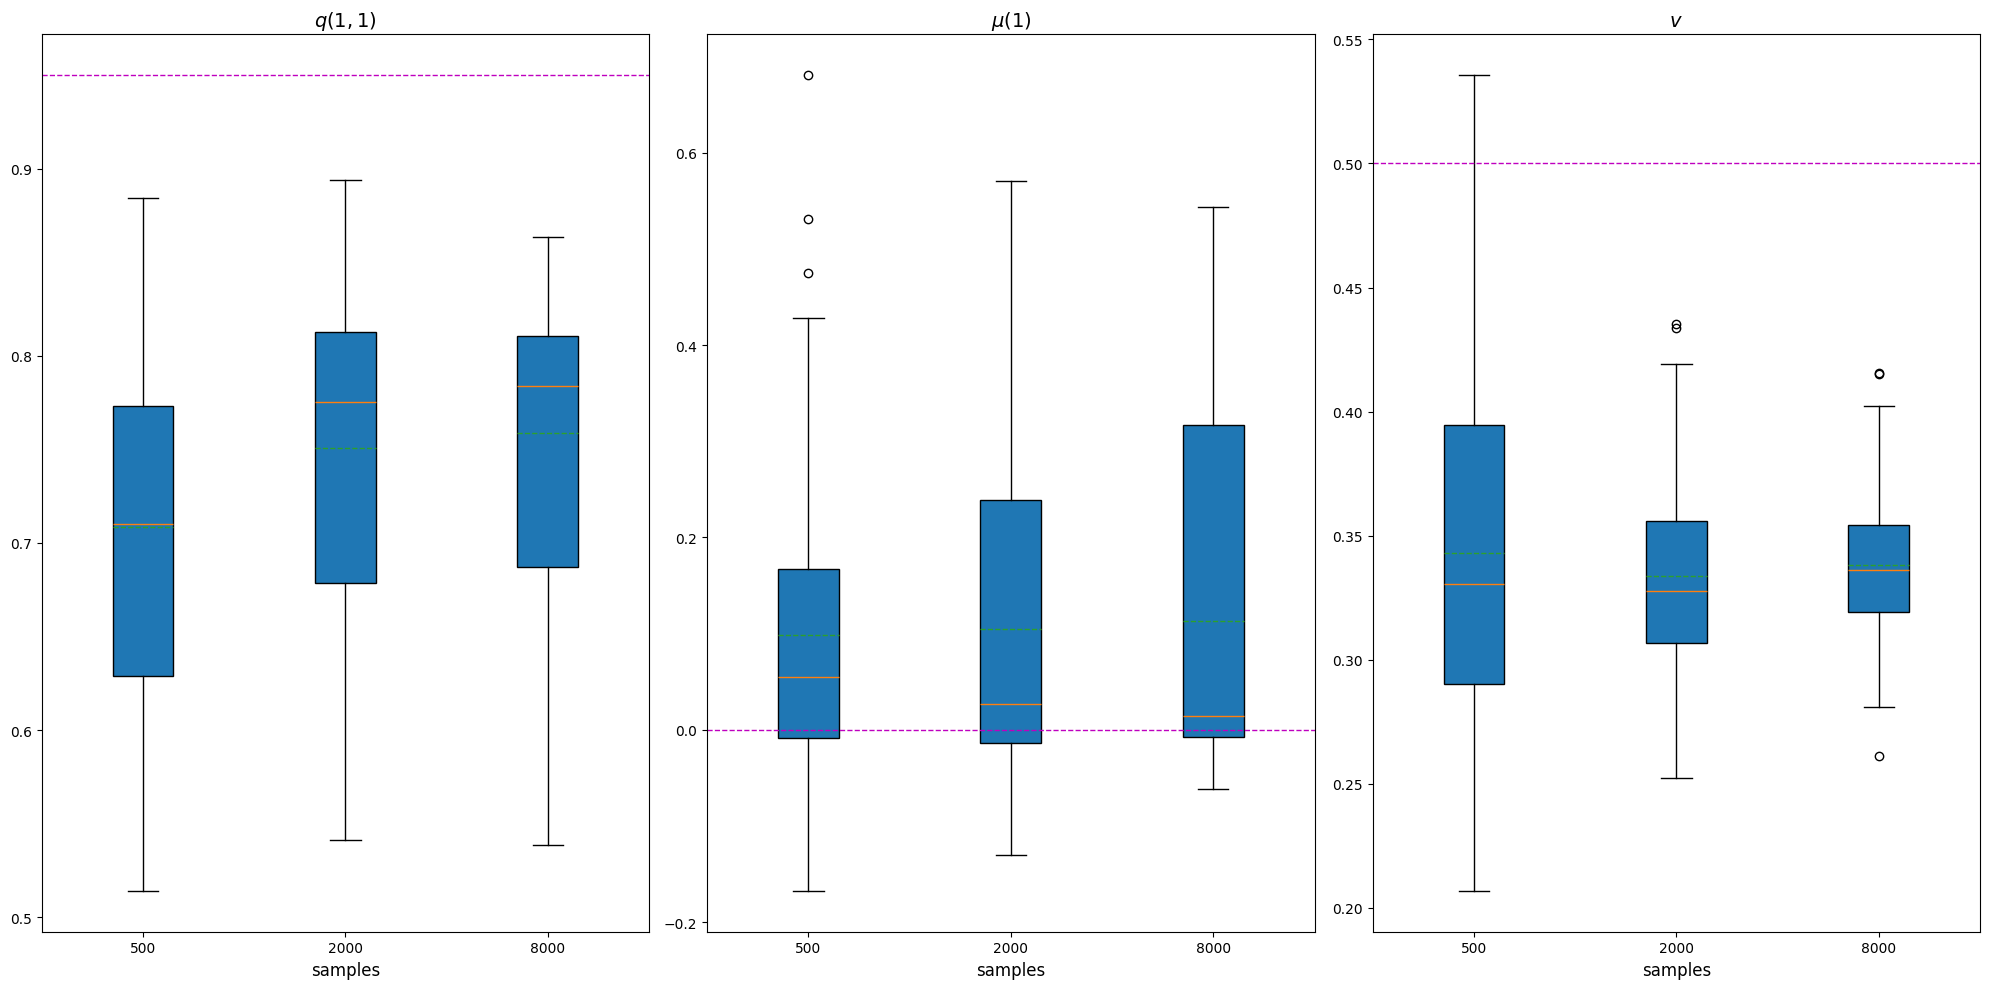

In [12]:
plot_parameter_boxplots(all_theta_updates)